In [1]:
import pandas as pd
import numpy as np
from keras import layers, models
from keras import callbacks
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


### Building a Multiple Input Multi-step output

- Use Func to split timeseries in to 6 steps in, 6 steps out

In [2]:
train = pd.read_csv('data/TrainingSet_Cleaned.csv',index_col=0)
submission = pd.read_csv('data/SubmissionRows.csv',index_col=0)

In [3]:
train.head()

,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,...,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007
16,NaN,NaN,0.267007,0.26767,0.268333,0.268997,0.26966,0.270323,0.270986,0.27165,...,0.279609,0.279609,0.279609,0.279609,0.279609,0.279609,0.279609,0.279609,0.279609,0.279609
243,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,52.800000,75.200000,67.400000,84.600000
559,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.152000,0.187000,0.221000,0.256000,0.291000,0.325000,0.360000,0.395000,0.430000,0.465000
618,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000034,0.000039,0.000043,0.000047,0.000046,0.000879,0.001058,0.012241,0.021071,0.019000
660,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,11.600000,11.800000,12.000000,13.600000,15.200000,16.800000,18.400000,20.000000,20.000000,20.000000


In [5]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the dataset
		if out_end_ix > len(sequences):
			break
		# gather input and output parts of the pattern: target is the next n_steps_out rows at the end of n_steps_in
		seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [6]:
# Scaler:
scaler = MinMaxScaler()

# Train, Test sets
data = train.loc[:,'1980':'2007'].T

data = scaler.fit_transform(data)

# Back to DF: Consider timeframe 1990 >
data = pd.DataFrame(data,index=train.loc[:,'1980':'2007'].columns,columns=train.loc[:,'1980':'2007'].index)

### Fill rest of nan values with -1:
data = data.fillna(-1)

# Back to numpy:
data = data.values

# Timesteps as input/Output:
n_steps_in =5
n_steps_out = 5

X, y = split_sequences(data,n_steps_in,n_steps_out)

n_features = X.shape[2]

In [9]:
X[1].shape

(5, 4068)

In [201]:
# Shape of X, y:
print('Shape of X : ',X.shape)
print('Shape of y : ',y.shape) # 737 rows to predict

Shape of X :  (19, 5, 4068)
Shape of y :  (19, 5, 4068)


### LSTM Network:

Multivariate network, multi-output, predict the 2008 for the submission years

- Predicts 5 timesteps ahead (years)

- Encoder - Decoder LSTM model

- Wrapping output into a TimeDistributed layer

- 2 Layer, 200 hidden units

- Train 1000 Epochs, validation split 20% (training data)

- Early stopping round (patience = 50)

- Save best model with ModelCheckpoint

Goal: To predict 2008 (Target), 2009, 2010, 2011, 2012 (Target)

In [205]:
def model_LSTM(units,epochs,n_steps_in,n_steps_out,n_features,X,y):
    # Define model:
    model = models.Sequential()
    model.add(layers.Masking(mask_value=-1,input_shape=(n_steps_in,n_features)))
    model.add(layers.LSTM(units, activation='relu',return_sequences=True))
    model.add(layers.TimeDistributed(layers.Dense(y.shape[2])))
    # compile:
    model.compile(optimizer='adam',loss='mse',metrics=['mean_squared_error'])

    # Early stopping round, Model Checkpoint
    es = callbacks.EarlyStopping(monitor='val_mean_squared_error',mode='min',patience=60,verbose=1)
    mc = callbacks.ModelCheckpoint('ts_un.h5',save_best_only=True,monitor='val_mean_squared_error',mode='min',verbose=1)

    # Fit:
    history = model.fit(X,y,validation_split=0.1,epochs=epochs,shuffle=False,callbacks=[es,mc])
    #plot:
    plt.figure(figsize=(10,8))
    plt.plot(history.history['val_loss'],label='val_loss')
    plt.plot(history.history['loss'],label='loss')
    plt.legend()

Train on 17 samples, validate on 2 samples
Epoch 1/1000
17/17 [==============================] - 10s 576ms/step - loss: 0.5991 - mean_squared_error: 0.5991 - val_loss: 0.4781 - val_mean_squared_error: 0.4781

Epoch 00001: val_mean_squared_error improved from inf to 0.47814, saving model to ts_un.h5
Epoch 2/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.6981 - mean_squared_error: 0.6981 - val_loss: 0.4689 - val_mean_squared_error: 0.4689

Epoch 00002: val_mean_squared_error improved from 0.47814 to 0.46885, saving model to ts_un.h5
Epoch 3/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.7036 - mean_squared_error: 0.7036 - val_loss: 0.5062 - val_mean_squared_error: 0.5062

Epoch 00003: val_mean_squared_error did not improve from 0.46885
Epoch 4/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.6008 - mean_squared_error: 0.6008 - val_loss: 0.4439 - val_mean_squared_error: 0.4439

Epoch 00004: val_mean_squared_error improved from 0

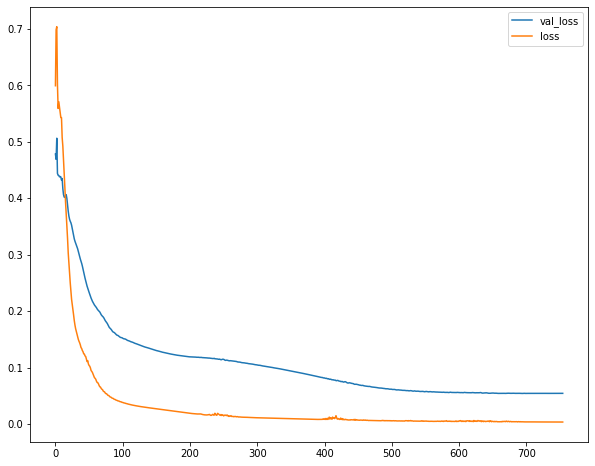

In [206]:
model = model_LSTM(units=128,epochs=1000,X=X,y=y,n_steps_in=n_steps_in,n_steps_out=n_steps_out,n_features=n_features)

### Building model:

- Encoder ,Decoder

In [185]:
# Define model: 128 units
model = models.Sequential()
model.add(layers.Masking(mask_value=-1,input_shape=(n_steps_in,n_features)))
model.add(layers.LSTM(128, activation='relu'))
model.add(layers.RepeatVector(n_steps_out))
model.add(layers.LSTM(128, activation='relu', return_sequences=True))
model.add(layers.TimeDistributed(layers.Dense(y.shape[2])))
# compile:
model.compile(optimizer='adam',loss='mse',metrics=['mean_absolute_error'])

# Early stopping round, Model Checkpoint
es = callbacks.EarlyStopping(monitor='val_mean_absolute_error',mode='min',patience=200,verbose=1)
mc = callbacks.ModelCheckpoint('ts_un.h5',save_best_only=True,monitor='val_mean_absolute_error',mode='min',verbose=1)

# Fit:
history = model.fit(X,y,validation_split=0.1,epochs=2000,shuffle=False,callbacks=[es,mc])

Train on 4 samples, validate on 1 samples
Epoch 1/2000
4/4 [==============================] - 10s 3s/step - loss: 0.4706 - mean_absolute_error: 0.5640 - val_loss: 0.4491 - val_mean_absolute_error: 0.5414

Epoch 00001: val_mean_absolute_error improved from inf to 0.54145, saving model to ts_un.h5
Epoch 2/2000
4/4 [==============================] - 0s 21ms/step - loss: 0.4787 - mean_absolute_error: 0.5782 - val_loss: 0.5039 - val_mean_absolute_error: 0.5816

Epoch 00002: val_mean_absolute_error did not improve from 0.54145
Epoch 3/2000
4/4 [==============================] - 0s 20ms/step - loss: 0.5036 - mean_absolute_error: 0.5908 - val_loss: 0.4576 - val_mean_absolute_error: 0.5525

Epoch 00003: val_mean_absolute_error did not improve from 0.54145
Epoch 4/2000
4/4 [==============================] - 0s 20ms/step - loss: 0.5056 - mean_absolute_error: 0.5938 - val_loss: 0.4222 - val_mean_absolute_error: 0.5254

Epoch 00004: val_mean_absolute_error improved from 0.54145 to 0.52537, saving m

In [207]:
# X_test:
X_input = data[-5:,:].reshape(1,5,data.shape[1])

In [208]:
# Predict: Load Model
saved_model = models.load_model('ts_un.h5')

In [210]:
y_pred_2008_2012 = saved_model.predict(X_input)

In [211]:
y_pred_2008_2012 = y_pred_2008_2012.reshape(5,y_pred_2008_2012.shape[2])

In [212]:
# Build back DF:
index_years = list(train.loc[:,'1980':'2007'].columns) + [str(x) for x in range(2008,2013)]
columns = list(train.loc[:,'1980':'2007'].index)
df_1972_2012 = pd.DataFrame(np.concatenate([data,y_pred_2008_2012]),index=index_years,columns=columns)


In [213]:
df_1972_2012.values

array([[ 0.        , -1.        , -1.        , ..., -1.        ,
        -1.        , -1.        ],
       [ 0.07692308, -1.        , -1.        , ..., -1.        ,
        -1.        , -1.        ],
       [ 0.15384615, -1.        , -1.        , ..., -1.        ,
        -1.        , -1.        ],
       ...,
       [ 2.13950515, -3.7181623 , -2.43042183, ..., -0.94937801,
        -5.19911671, -2.32720351],
       [ 2.74186516, -4.50668478, -3.22087717, ..., -1.49834228,
        -7.06807995, -2.18345833],
       [ 3.16676474, -2.86732125, -2.83485985, ..., -0.60142666,
        -6.84984684, -2.39841199]])

In [214]:
# Put into right format
df_1972_2012_unscaled = scaler.inverse_transform(df_1972_2012.values)

df_1972_2012_unscaled = pd.DataFrame(df_1972_2012_unscaled,index=index_years,columns=columns)

df_1972_2012_unscaled = df_1972_2012_unscaled.T



In [217]:
df_1972_2012_unscaled = df_1972_2012_unscaled.T

In [218]:
# Incase values became negative:
df_1972_2012_unscaled = df_1972_2012_unscaled[['2008','2012']].applymap(lambda x: abs(x))

In [219]:
# Submission columns:
df_pred = df_1972_2012_unscaled.loc[submission.index,:]

df_pred.columns = submission.columns

In [220]:
df_pred.to_csv('Final_Pred.csv')